In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
final_df = pd.read_csv("../half_season/h1_dfs/final_in_poss_df_H1.csv")
team_ids_h1 = final_df['uniqueTeamId']
final_df.set_index("uniqueTeamId", inplace = True)
final_df = final_df.fillna(0)
final_df_h2 = pd.read_csv("../half_season/h2_dfs/final_in_poss_df_H2.csv")
team_ids_h2 = final_df_h2['uniqueTeamId']
final_df_h2 = final_df_h2.fillna(0)
final_df_h2.set_index("uniqueTeamId", inplace = True)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from kmedoids import KMedoids
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import calculate_distance_matrix
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

    # Autoencoder for DEC
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, z):
        return self.model(z)

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


    # DEC model
class DEC(nn.Module):
    def __init__(self, encoder, cluster_centers):
        super().__init__()
        self.encoder = encoder
        self.clusters = nn.Parameter(cluster_centers)

    def forward(self, x):
        z = self.encoder(x)
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.clusters)**2, dim=2))
        q = q / torch.sum(q, dim=1, keepdim=True)
        return q

# Target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

def compute_indices(X, labels):
    n_clusters = len(np.unique(labels))
    cluster_centers = []
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) == 0:
            cluster_centers.append(np.zeros(X.shape[1]))
        else:
            cluster_centers.append(cluster_points.mean(axis=0))
    cluster_centers = np.array(cluster_centers)

    distances = pairwise_distances(X, cluster_centers)

    # Iwcss: Sum of squared distances to cluster centers
    Iwcss = sum(np.sum((X[labels == i] - cluster_centers[i]) ** 2) for i in range(n_clusters))

    # Isep: Mean distance between all cluster centers
    Isep = np.mean(cdist(cluster_centers, cluster_centers))

    # Idistcc and Idens with filtering for valid clusters
    valid_dists = []
    valid_dens = []
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) < 2:
            continue  # Skip small clusters to avoid NaN in mean/std
        distances_to_center = np.linalg.norm(cluster_points - cluster_centers[i], axis=1)
        valid_dists.append(np.mean(distances_to_center))
        valid_dens.append(np.std(distances_to_center))

    # Default to 0 if all clusters were invalid
    Idistcc = np.mean(valid_dists) if valid_dists else 0.0
    Idens = np.mean(valid_dens) if valid_dens else 0.0

    return Iwcss, Isep, Idistcc, Idens



def normalize(val, min_val, max_val, larger_is_better):
    range_ = max_val - min_val
    if np.isclose(range_, 0):
        return 1.0  # or 0.5, depending on how you want to treat flat metrics
    if larger_is_better:
        return np.clip((val - min_val) / (range_ + 1e-10), 0, 1)
    else:
        return np.clip(1 - (val - min_val) / (range_ + 1e-10), 0, 1)

In [4]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# If using GPU
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

scaler = StandardScaler()
X_h1 = scaler.fit_transform(final_df)          # FIT on H1
X_h2 = scaler.transform(final_df_h2)           # TRANSFORM H2

pca2 = PCA(n_components=2, random_state=42)
X_h1_pca = pca2.fit_transform(X_h1)            # FIT on H1
X_h2_pca = pca2.transform(X_h2)                # TRANSFORM H2

X_h1_tensor = torch.tensor(X_h1, dtype=torch.float32)
X_h2_tensor = torch.tensor(X_h2, dtype=torch.float32)



dec_loss = {}

from sklearn.metrics import pairwise_distances_argmin



In [5]:
# Store results
results = []

def predict_via_centroids(X_train, y_train, X_eval):
    centers = np.vstack([X_train[y_train == c].mean(axis=0) for c in np.unique(y_train)])
    return pairwise_distances_argmin(X_eval, centers)  # nearest center id

def append_eval(k, method, X_eval, y_eval, split_tag):
    sil = silhouette_score(X_eval, y_eval)
    Iwcss, Isep, Idistcc, Idens = compute_indices(X_eval, y_eval)
    results.append({
        "k": k,
        "method": method,
        "split": split_tag,
        "silhouette_score": sil,
        "Iwcss": Iwcss,
        "Isep": Isep,
        "Idistcc": Idistcc,
        "Idens": Idens
    })

for k in range(2, 11):
    clusterings = {
        "kmeans": KMeans(n_clusters=k, random_state=42),
        "kmedoids": KMedoids(n_clusters=k, metric="euclidean", init="random", max_iter=300, random_state=42),
        "ward": AgglomerativeClustering(n_clusters=k, linkage="ward"),
    }

    # ====== RAW space (scaled) ======
    for method_name, model in clusterings.items():
        y_h1 = model.fit_predict(X_h1)

        # Evaluate on H1
        append_eval(k, method_name, X_h1, y_h1, "H1")

        # Labels for H2 (predict if possible; else centroid assignment)
        if hasattr(model, "predict"):
            y_h2 = model.predict(X_h2)
        else:
            y_h2 = predict_via_centroids(X_h1, y_h1, X_h2)

        # Evaluate on H2
        append_eval(k, method_name, X_h2, y_h2, "H2")

    # ====== PCA space ======
    for method_name, model in clusterings.items():
        y_h1 = model.fit_predict(X_h1_pca)

        append_eval(k, f"{method_name}_pca", X_h1_pca, y_h1, "H1")

        if hasattr(model, "predict"):
            y_h2 = model.predict(X_h2_pca)
        else:
            y_h2 = predict_via_centroids(X_h1_pca, y_h1, X_h2_pca)

        append_eval(k, f"{method_name}_pca", X_h2_pca, y_h2, "H2")


In [24]:
# Store traditiional_results
traditiional_results = []

from sklearn.metrics import pairwise_distances_argmin

def predict_via_centroids(X_train, y_train, X_eval):
    centers = np.vstack([X_train[y_train == c].mean(axis=0) for c in np.unique(y_train)])
    return pairwise_distances_argmin(X_eval, centers)

def predict_kmedoids_generalizable(model, X_h1, y_h1, X_h2):
    # Use H1 centroids as representatives for stable cross-split assignment
    return predict_via_centroids(X_h1, y_h1, X_h2)

def append_eval(k, method, X_eval, y_eval, split_tag):
    sil = silhouette_score(X_eval, y_eval)
    Iwcss, Isep, Idistcc, Idens = compute_indices(X_eval, y_eval)
    traditiional_results.append({
        "k": k,
        "method": method,
        "split": split_tag,
        "silhouette_score": sil,
        "Iwcss": Iwcss,
        "Isep": Isep,
        "Idistcc": Idistcc,
        "Idens": Idens
    })

for k in range(2, 11):
    clusterings = {
        "kmeans": KMeans(n_clusters=k, random_state=42),
        "kmedoids": KMedoids(n_clusters=k, metric="euclidean", init="random", max_iter=300, random_state=42),
        "ward": AgglomerativeClustering(n_clusters=k, linkage="ward"),
    }

    # ====== RAW space (scaled) ======
    for method_name, model in clusterings.items():
        y_h1 = model.fit_predict(X_h1)

        # Evaluate on H1
        append_eval(k, method_name, X_h1, y_h1, "H1")

        # Labels for H2 (cross-split comparable)
        if method_name == "kmedoids":
            y_h2 = predict_kmedoids_generalizable(model, X_h1, y_h1, X_h2)
        elif hasattr(model, "predict"):
            y_h2 = model.predict(X_h2)
        else:
            y_h2 = predict_via_centroids(X_h1, y_h1, X_h2)

        # Evaluate on H2
        append_eval(k, method_name, X_h2, y_h2, "H2")

    # ====== PCA space ======
    for method_name, model in clusterings.items():
        y_h1 = model.fit_predict(X_h1_pca)

        append_eval(k, f"{method_name}_pca", X_h1_pca, y_h1, "H1")

        if method_name == "kmedoids":
            y_h2 = predict_kmedoids_generalizable(model, X_h1_pca, y_h1, X_h2_pca)
        elif hasattr(model, "predict"):
            y_h2 = model.predict(X_h2_pca)
        else:
            y_h2 = predict_via_centroids(X_h1_pca, y_h1, X_h2_pca)

        append_eval(k, f"{method_name}_pca", X_h2_pca, y_h2, "H2")


In [6]:
results

[{'k': 2,
  'method': 'kmeans',
  'split': 'H1',
  'silhouette_score': 0.1625002017024088,
  'Iwcss': 44314.86042289942,
  'Isep': 2.3973042531817317,
  'Idistcc': 4.801924386015314,
  'Idens': 1.127991549111678},
 {'k': 2,
  'method': 'kmeans',
  'split': 'H2',
  'silhouette_score': 0.16889593374969977,
  'Iwcss': 44270.01380665036,
  'Isep': 2.441063769415178,
  'Idistcc': 4.801914949447071,
  'Idens': 1.1231403060433984},
 {'k': 2,
  'method': 'kmedoids',
  'split': 'H1',
  'silhouette_score': 0.15223468953195357,
  'Iwcss': 44726.60903859552,
  'Isep': 2.3523899937038775,
  'Idistcc': 4.791674421176289,
  'Idens': 1.141935007352418},
 {'k': 2,
  'method': 'kmedoids',
  'split': 'H2',
  'silhouette_score': 0.16049566337384355,
  'Iwcss': 0.0,
  'Isep': 0.0,
  'Idistcc': 0.0,
  'Idens': 0.0},
 {'k': 2,
  'method': 'ward',
  'split': 'H1',
  'silhouette_score': 0.12869987041791112,
  'Iwcss': 46141.67794844824,
  'Isep': 2.181446369206121,
  'Idistcc': 4.8592819817752515,
  'Idens': 1

In [7]:
def append_eval(k, method, X_eval, y_eval, split_tag):
    sil = silhouette_score(X_eval, y_eval)
    Iwcss, Isep, Idistcc, Idens = compute_indices(X_eval, y_eval)
    traditiional_results.append({
        "k": k,
        "method": method,
        "split": split_tag,
        "silhouette_score": sil,
        "Iwcss": Iwcss,
        "Isep": Isep,
        "Idistcc": Idistcc,
        "Idens": Idens
    })


for k in range(2, 11):
    print("---"*10)
    print(f"k == {k}")
    input_dim = X_h1.shape[1]
    latent_dim = 10

    ae = AutoEncoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ae.parameters(), lr=1e-3)

    print("AE training...")
    # AE pretrain on H1
    for epoch in range(3000):
        optimizer.zero_grad()
        out = ae(X_h1_tensor)
        loss = criterion(out, X_h1_tensor)
        loss.backward()
        optimizer.step()        
        if epoch % 500 == 0:
            print(f"Epoch: {epoch}")

    # init clusters using H1 latent
    z_h1 = ae.encoder(X_h1_tensor).detach().numpy()
    km = KMeans(n_clusters=k, random_state=42).fit(z_h1)
    init_centers = torch.tensor(km.cluster_centers_, dtype=torch.float32)

    dec = DEC(ae.encoder, init_centers.clone())
    dec_opt = optim.Adam(dec.parameters(), lr=1e-3)

    print("DEC training...")
    # DEC train on H1
    for epoch in range(3000): 
        q = dec(X_h1_tensor)
        p = target_distribution(q.detach())
        kl = torch.nn.functional.kl_div(q.log(), p, reduction="batchmean")
        dec_opt.zero_grad()
        kl.backward()
        dec_opt.step()
        if epoch % 500 == 0:
            print(f"Epoch: {epoch}")

    # ===== evaluate on H1 =====
    with torch.no_grad():
        z_h1_eval = dec.encoder(X_h1_tensor).cpu().numpy()
        q_h1 = dec(X_h1_tensor)
        y_h1_eval = torch.argmax(q_h1, dim=1).cpu().numpy()

    append_eval(k, "dec", z_h1_eval, y_h1_eval, "H1")

    # ===== evaluate on H2 =====
    with torch.no_grad():
        z_h2_eval = dec.encoder(X_h2_tensor).cpu().numpy()
        q_h2 = dec(X_h2_tensor)
        y_h2_eval = torch.argmax(q_h2, dim=1).cpu().numpy()

    append_eval(k, "dec", z_h2_eval, y_h2_eval, "H2")


------------------------------
k == 2
AE training...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
DEC training...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
------------------------------
k == 3
AE training...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
DEC training...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
------------------------------
k == 4
AE training...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
DEC training...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
------------------------------
k == 5
AE training...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
DEC training...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
------------------------------
k == 6
AE training...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
DEC training...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500

In [8]:
def minmax_normalize(val, min_val, max_val, larger_is_better):
    if np.isclose(max_val - min_val, 0):
        return 1.0
    score = (val - min_val) / (max_val - min_val)
    return score if larger_is_better else 1 - score

results_normalized = []

for split_tag in ["H1", "H2"]:
    rows = [r for r in results if r["split"] == split_tag]

    index_min = {
        'Iwcss': min(row['Iwcss'] for row in rows),
        'Isep': min(row['Isep'] for row in rows),
        'Idistcc': min(row['Idistcc'] for row in rows),
        'Idens': min(row['Idens'] for row in rows),
    }
    index_max = {
        'Iwcss': max(row['Iwcss'] for row in rows),
        'Isep': max(row['Isep'] for row in rows),
        'Idistcc': max(row['Idistcc'] for row in rows),
        'Idens': max(row['Idens'] for row in rows),
    }

    for row in rows:
        Iwcss_m = minmax_normalize(row['Iwcss'], index_min['Iwcss'], index_max['Iwcss'], larger_is_better=False)
        Isep_m  = minmax_normalize(row['Isep'],  index_min['Isep'],  index_max['Isep'],  larger_is_better=True)
        Idistcc_m = minmax_normalize(row['Idistcc'], index_min['Idistcc'], index_max['Idistcc'], larger_is_better=False)
        Idens_m   = minmax_normalize(row['Idens'],   index_min['Idens'],   index_max['Idens'],   larger_is_better=False)

        AC1_m = (Iwcss_m + Isep_m + Idistcc_m + Idens_m) / 4
        AC2_m = (1 * Iwcss_m + 0.5 * Isep_m + 1 * Idistcc_m + 0.25 * Idens_m) / 2.75

        results_normalized.append({
            'k': row['k'],
            'method': row['method'],
            'split': row['split'],
            'silhouette_score': row['silhouette_score'],
            'AC1': AC1_m,
            'AC2': AC2_m
        })

df = pd.DataFrame(results_normalized)


In [ ]:
# method mapping
old_methods = ['dec', 'kmeans', 'kmeans_pca', 'kmedoids', 'kmedoids_pca', 'ward', 'ward_pca']
new_methods = ['DEC (proposed method)', 'K-Means', 'K-Means_with_pca', 'K-Medoids', 'K-Medoids_with_pca', 'Ward', 'Ward_with_pca']
method_map = dict(zip(old_methods, new_methods))
df['method'] = df['method'].map(method_map)

In [40]:
def minmax_normalize(val, min_val, max_val, larger_is_better):
    if np.isclose(max_val - min_val, 0):
        return 1.0
    score = (val - min_val) / (max_val - min_val)
    return score if larger_is_better else 1 - score

traditiional_results_normalized_trad = []

for split_tag in ["H1", "H2"]:
    rows = [r for r in traditiional_results if r["split"] == split_tag]

    index_min = {
        'Iwcss': min(row['Iwcss'] for row in rows),
        'Isep': min(row['Isep'] for row in rows),
        'Idistcc': min(row['Idistcc'] for row in rows),
        'Idens': min(row['Idens'] for row in rows),
    }
    index_max = {
        'Iwcss': max(row['Iwcss'] for row in rows),
        'Isep': max(row['Isep'] for row in rows),
        'Idistcc': max(row['Idistcc'] for row in rows),
        'Idens': max(row['Idens'] for row in rows),
    }

    for row in rows:
        Iwcss_m = minmax_normalize(row['Iwcss'], index_min['Iwcss'], index_max['Iwcss'], larger_is_better=False)
        Isep_m  = minmax_normalize(row['Isep'],  index_min['Isep'],  index_max['Isep'],  larger_is_better=True)
        Idistcc_m = minmax_normalize(row['Idistcc'], index_min['Idistcc'], index_max['Idistcc'], larger_is_better=False)
        Idens_m   = minmax_normalize(row['Idens'],   index_min['Idens'],   index_max['Idens'],   larger_is_better=False)

        AC1_m = (Iwcss_m + Isep_m + Idistcc_m + Idens_m) / 4
        AC2_m = (1 * Iwcss_m + 0.5 * Isep_m + 1 * Idistcc_m + 0.25 * Idens_m) / 2.75

        traditiional_results_normalized_trad.append({
            'k': row['k'],
            'method': row['method'],
            'split': row['split'],
            'silhouette_score': row['silhouette_score'],
            'AC1': AC1_m,
            'AC2': AC2_m
        })

df_trad = pd.DataFrame(traditiional_results_normalized_trad)

In [42]:
df_dec = df[df['method'] == 'DEC (proposed method)']
df = pd.concat([df_trad,df_dec])

In [103]:
# method mapping
df = df[df.method.isin(['kmeans', 'ward', 'kmedoids', 'DEC (proposed method)'])].copy()
old_methods = ['DEC (proposed method)', 'kmeans', 'kmedoids', 'ward'] #,'kmeans_pca',  'kmedoids_pca',  'ward_pca']
new_methods = ['DEC (proposed method)', 'K-Means', 'K-Medoids', 'Ward'] #,'K-Means_with_pca',  'K-Medoids_with_pca',  'Ward_with_pca']
method_map = dict(zip(old_methods, new_methods))
df['method'] = df['method'].map(method_map)

df['k'] = df['k'].astype(int)
for col in ['silhouette_score', 'AC1', 'AC2']:
    df[col] = df[col].astype(float)

methods = new_methods
#df

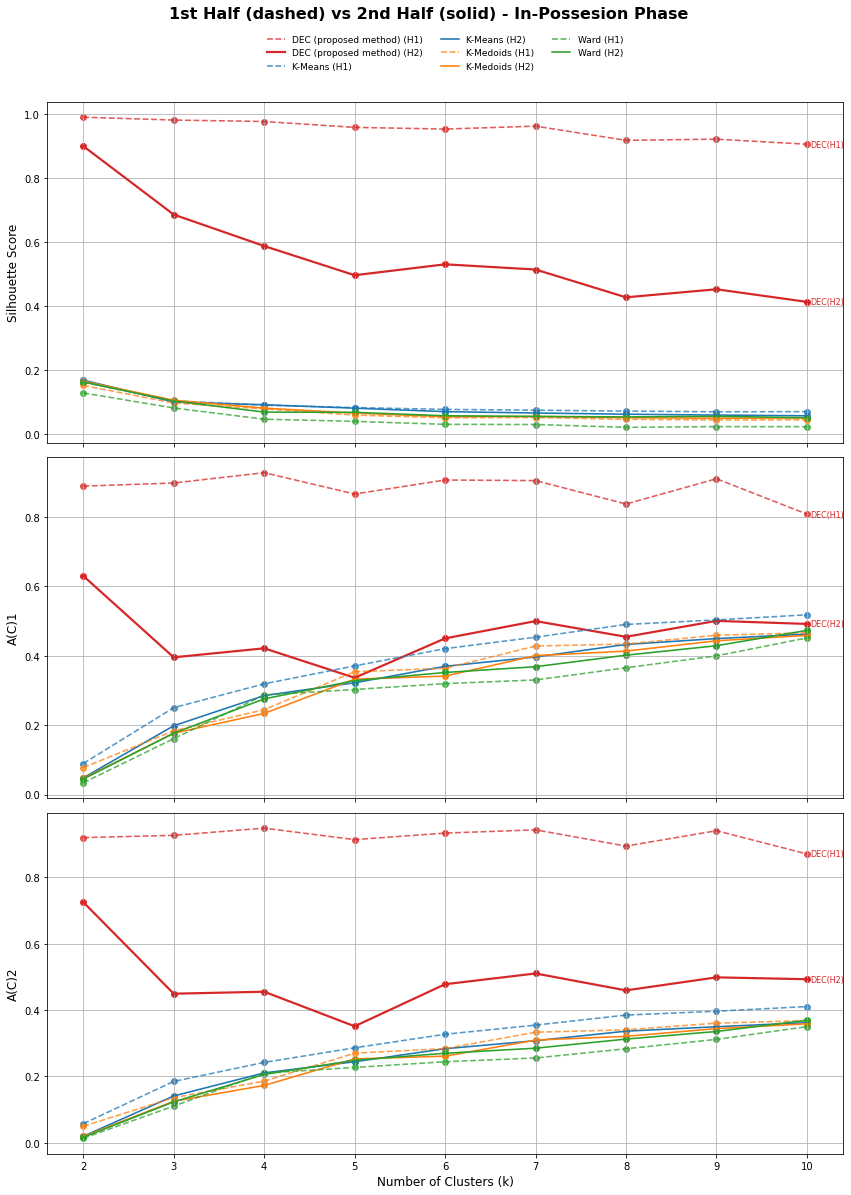

In [111]:
## method mapping
#df = df[df.method.isin(['kmeans', 'ward', 'kmedoids', 'DEC (proposed method)'])].copy()
#old_methods = ['DEC (proposed method)', 'kmeans', 'kmedoids', 'ward'] #,'kmeans_pca',  'kmedoids_pca',  'ward_pca']
#new_methods = ['DEC (proposed method)', 'K-Means', 'K-Medoids', 'Ward'] #,'K-Means_with_pca',  'K-Medoids_with_pca',  'Ward_with_pca']
#method_map = dict(zip(old_methods, new_methods))
#df['method'] = df['method'].map(method_map)
#
#df['k'] = df['k'].astype(int)
#for col in ['silhouette_score', 'AC1', 'AC2']:
#    df[col] = df[col].astype(float)
#
#methods = new_methods

base_colors = {
    'DEC (proposed method)': '#d62728',
    'K-Means': '#1f77b4',
    #'K-Means_with_pca': '#1f77b4',
    'K-Medoids': '#ff7f0e',
    #'K-Medoids_with_pca': '#ff7f0e',
    'Ward': '#2ca02c',
    #'Ward_with_pca': '#2ca02c'
}

split_alpha = {"H1": 0.75, "H2": 1.0}
split_ls    = {"H1": "--", "H2": "-"}

fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
metrics = ['silhouette_score', 'AC1', 'AC2']
ylabels = ['Silhouette Score', 'A(C)1', 'A(C)2']

for ax, metric, ylabel in zip(axs, metrics, ylabels):
    for method in methods:
        for split_tag in ["H1", "H2"]:
            subset = df[(df['method'] == method) & (df['split'] == split_tag)].sort_values("k")
            x = subset['k'].to_numpy()
            y = subset[metric].to_numpy()

            ax.plot(
                x, y,
                label=f"{method} ({split_tag})",
                color=base_colors[method],
                alpha=split_alpha[split_tag],
                linestyle=split_ls[split_tag],
                linewidth=2.2 if (method == 'DEC (proposed method)' and split_tag == "H2") else 1.6
            )
            ax.scatter(x, y, color=base_colors[method], alpha=split_alpha[split_tag], s=35)

            if method == 'DEC (proposed method)':
                ax.text(x[-1] + 0.04, y[-1], f'DEC({split_tag})', color=base_colors[method],
                    fontsize=8, va='center') #fontweight='bold', va='center')
            

    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True)

axs[-1].set_xlabel('Number of Clusters (k)', fontsize=12)
fig.suptitle("1st Half (dashed) vs 2nd Half (solid) - In-Possesion Phase", fontsize=16, fontweight='bold', y=.95)

axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=3, fontsize=9, frameon=False)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [113]:
pd.DataFrame(results).to_excel("results_in_poss.xlsx")